In [58]:
import numpy as np
import pandas as pd
from pymongo import MongoClient

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer

import matplotlib.pyplot as plt

from subprocess import check_output
from datetime import time

#Connect to MongoDB
conn = MongoClient("localhost", 27017)
db = conn["crowd-db"]
sensor_e1 = db["e1"]

#Load Data From DB
cursor = sensor_e1.find()
df = pd.DataFrame(list(cursor))

#Drop _ids
del df['_id']

df.head()

,dayOfMonth,dayOfWeek,is_weekend,hour,packetEvents
0,13,0,0,0,198
1,13,0,0,1,119
2,13,0,0,2,193
3,13,0,0,3,50
4,13,0,0,4,150


In [59]:
#because data is less than one month there is no point in involving dayOfMonth
df = df.drop("dayOfMonth", axis=1)
df.head()

,dayOfWeek,is_weekend,hour,packetEvents
0,0,0,0,198
1,0,0,1,119
2,0,0,2,193
3,0,0,3,50
4,0,0,4,150


In [60]:
#one hot encode categorical columns
columns = ["dayOfWeek", "hour"]

encoder = LabelBinarizer()
dow = pd.DataFrame(encoder.fit_transform(df['dayOfWeek']))
hour = pd.DataFrame(encoder.fit_transform(df['hour']))

oh_df = pd.concat([df, dow, hour], axis=1).drop(['dayOfWeek','hour'], axis=1)
oh_df

,is_weekend,packetEvents,0,1,2,3,4,5,6,0,...,15,16,17,18,19,20,21,22,23,24
0,0,198,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,119,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,193,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,50,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,150,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,1,389,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
346,1,409,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
347,1,417,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
348,1,409,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [61]:
X = oh_df.drop("packetEvents", axis=1)
y = oh_df["packetEvents"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [62]:
# Scale the data to be between -1 and 1
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [63]:
# Establish model
model = RandomForestRegressor(n_jobs=-1)

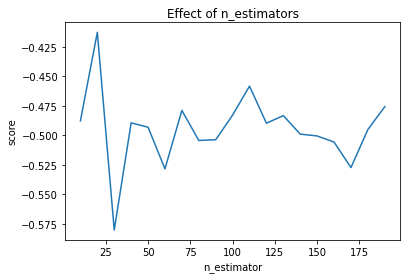

In [64]:
# Try different numbers of n_estimators
estimators = np.arange(10, 200, 10)
scores = []
for n in estimators:
    model.set_params(n_estimators=n)
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))
plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("score")
plt.plot(estimators, scores)

In [65]:
model.set_params(n_estimators=50)
model.fit(X, y)

RandomForestRegressor(n_estimators=50, n_jobs=-1)

In [70]:
#predict sample data
pdata = [{'dayOfMonth':13,'dayOfWeek':5,'is_weekend':0,'hour':15}]
K = pd.DataFrame.from_records(pdata)
K.head()

,dayOfMonth,dayOfWeek,is_weekend,hour
0,13,5,0,15


In [71]:
K = K.drop("dayOfMonth", axis=1)
encoder.fit(df['dayOfWeek'])
dow = pd.DataFrame(encoder.transform(K['dayOfWeek']))
encoder.fit(df['hour'])
hour = pd.DataFrame(encoder.transform(K['hour']))

oh_K = pd.concat([K, dow, hour], axis=1).drop(['dayOfWeek','hour'], axis=1)
oh_K

,is_weekend,0,1,2,3,4,5,6,0,1,...,15,16,17,18,19,20,21,22,23,24
0,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [72]:
model.predict(oh_K)

array([670.884])